<a href="https://colab.research.google.com/github/ll3708031210-ai/Topic-5/blob/main/Copy_of_MLP3_FashionMNIST_Sigmoid_80_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Multi-Layer Perceptron (MLP) Image Classifier With Fashion MNIST Dataset

In this example, we will train an MLP model to classify images from the Fashion MNIST database.

The Fashion MNIST dataset is a widely used dataset in Deep Learning for training and testing various algorithms. It was created as a replacement for the original handwritten digits MNIST dataset to provide a more challenging classification task.

Here are some key details about the Fashion MNIST dataset:
- The dataset consists of 70,000 grayscale images of fashion products from 10 different categories
- Each image is a 28x28 pixel square
- The dataset consists of a training dataset of 60,000 images and a test dataset of 10,000 images
- In this example, the test dataset is divided into validation and test sets, each containing 5,000 samples.

The goal is to classify each image into one of the 10 fashion categories, such as T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot

<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/mlp_fmnist.png'>


References:
- [Image Classifier using PyTorch and Keras](https://medium.com/dataseries/image-classifier-using-pytorch-and-keras-555007a50c2e)

- [Basic Syntax of the Markdown elements.](https://www.markdownguide.org/basic-syntax/)

- Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist

## Assignment 1: Summary Report

Provide your assignment report here. Write a summary report of your model architecture design, training process, experimental results, evaluation, and conclusions. Discuss which techniques work well and how you could improve the baseline model. Include relevant visualizations.

.....

.....

.....

# Starting of your code

In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with Fashion-MNIST dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import pickle
import sys
import time
import os

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 12, 12)
PyTorch version: 2.9.0+cu128
Device: cuda


In [ ]:
# Set seed for reproducibility
# Students are required to use the last 4 digits of the student ID card as the seed number for Assignment 1 submission
seed = 2078
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Download Fashion MNIST Dataset

This code snippet creates DataLoaders to facilitate the downloading of the training and test sets. The Fashion MNIST training dataset, consisting of 60,000 samples, is used to train the Model. The test dataset is randomly split into a validation set and a test set, each containing 5,000 samples. The data loaders are employed to provide batches of data from the datasets for iteration. The training data comprises batches of images, with each image measuring 28 x 28 pixels. The corresponding labels indicate the correct Fashion labels ("T-shirt," "Trouser," "Pullover," etc.) for each image.


In [ ]:
# =====================================================================
# TECHNIQUE 6: Data Augmentation
# Adding random transformations to training data to increase diversity
# and reduce overfitting. The model sees slightly different versions
# of each image every epoch, which improves generalization.
# =====================================================================

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),                        # Randomly flip images horizontally
    transforms.RandomRotation(10),                                  # Random rotation up to ±10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),      # Random translation up to 10%
    transforms.ToTensor(),                                          # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))                           # Normalize to [-1, 1]
])

# No augmentation for validation/test (we want to evaluate on clean data)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Split test dataset into validation (5000) and test (5000) sets
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Class labels
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 60000
Validation set size: 5000
Test set size: 5000


##Visualize image for each class
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

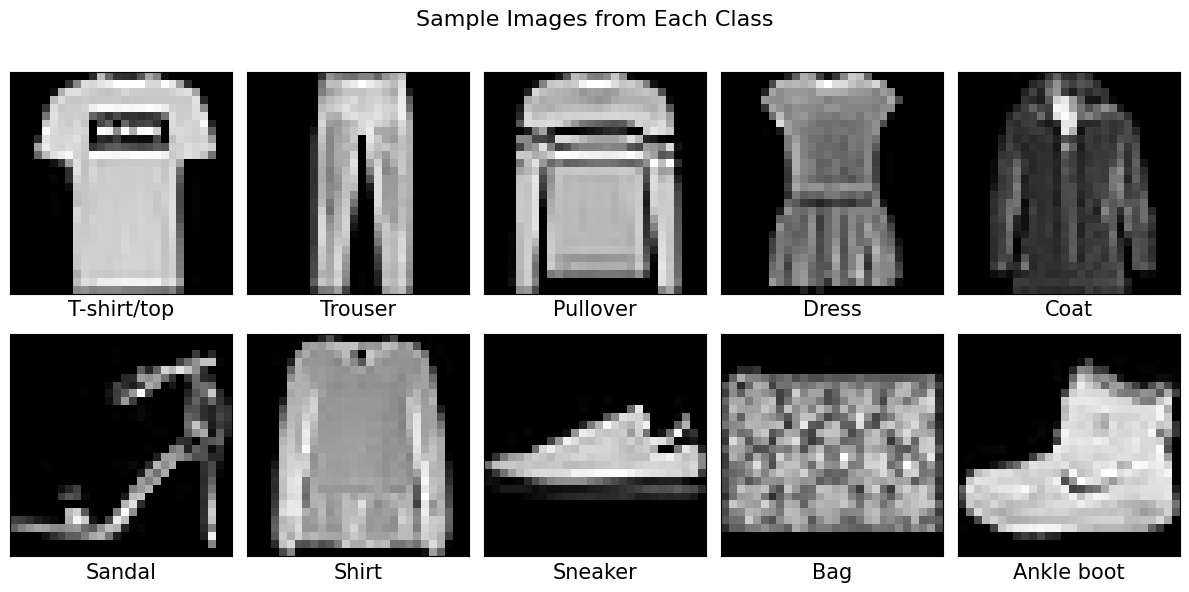

In [ ]:
# Visualize training image for each class
# Need to load data without augmentation for clean visualization
vis_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False)
sample_images = [vis_set.data[np.asarray(vis_set.targets) == label][0] for label in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel(classes[i], fontsize=15)
        axis.imshow(sample_images[i], cmap='gray')
        i += 1
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

# Define the MLP Network Architecture

The following code defines a class called MLPNet which inherits from nn.Module. The network has 3 fully-connected layers:

- fc1 takes the 784-pixel Fashion MNIST image as input and outputs 128 nodes
- fc2 takes the 128 nodes and outputs 64 nodes
- fc3 takes the 64 nodes and outputs predictions for the 10 classes

The forward method defines the forward pass through the network. It applies Sigmoid activation on the first two layers and log softmax on the output layer.

In [ ]:
# =====================================================================
# TECHNIQUE 1: Varying layers and neurons
#   - Deeper network: 6 linear layers (vs. 3 in baseline)
#   - Wider layers: 512, 256, 128 neurons (vs. 128, 64)
#
# TECHNIQUE 2: Different activation function
#   - GELU instead of Sigmoid (avoids vanishing gradient problem)
#
# TECHNIQUE 4: Regularization
#   - Dropout layers (randomly zero out neurons during training)
#   - L2 regularization via weight_decay in optimizer (see Cell 8)
#
# TECHNIQUE 5: Batch Normalization
#   - BatchNorm1d after each linear layer (stabilizes & accelerates training)
#
# ADVANCED: Skip/Residual Connections
#   - Allow gradients to flow directly through the network
#   - Enables training of deeper architectures
# =====================================================================

class ResidualBlock(nn.Module):
    """
    A residual block with skip connection.

    The idea: instead of learning f(x), we learn f(x) + x.
    This makes it easier for the network to learn identity mappings
    and helps gradients flow through deep networks.

    Architecture:
        Input (x) ──┬──→ Linear → BatchNorm → GELU → Dropout → Linear → BatchNorm ──→ (+) → GELU → Output
                     │                                                                  ↑
                     └──────────────────── Skip Connection ─────────────────────────────┘
    """
    def __init__(self, dim, dropout_rate=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.block(x) + x   # Skip connection: add input to output
        out = self.activation(out)
        out = self.dropout(out)
        return out


class ImprovedMLP(nn.Module):
    """
    Improved MLP for Fashion MNIST classification.

    Architecture: 784 → 512 → [ResBlock 512] → 256 → [ResBlock 256] → 128 → 10

    Improvements over baseline:
    1. More layers and wider architecture
    2. GELU activation (smooth, non-monotonic, avoids dead neurons)
    3. Batch normalization (faster convergence, regularization effect)
    4. Dropout regularization (prevents overfitting)
    5. Residual/skip connections (enables deeper training)
    6. Kaiming weight initialization (proper scaling for ReLU-family)
    7. Raw logits output (correct usage with CrossEntropyLoss)
    """
    def __init__(self, dropout_rate=0.3):
        super().__init__()

        # ---- Input Projection: 784 → 512 ----
        self.input_proj = nn.Sequential(
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

        # ---- Residual Block at 512 dimensions ----
        self.res_block1 = ResidualBlock(512, dropout_rate)

        # ---- Downsample: 512 → 256 ----
        self.down1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

        # ---- Residual Block at 256 dimensions ----
        self.res_block2 = ResidualBlock(256, dropout_rate)

        # ---- Downsample: 256 → 128 ----
        self.down2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

        # ---- Classifier Head: 128 → 10 ----
        self.classifier = nn.Linear(128, 10)

        # ---- Weight Initialization ----
        self._initialize_weights()

    def _initialize_weights(self):
        """Kaiming initialization for better convergence with GELU/ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(-1, 784)        # Flatten: (batch, 1, 28, 28) → (batch, 784)
        x = self.input_proj(x)     # 784 → 512
        x = self.res_block1(x)     # 512 → 512 (with skip connection)
        x = self.down1(x)          # 512 → 256
        x = self.res_block2(x)     # 256 → 256 (with skip connection)
        x = self.down2(x)          # 256 → 128
        x = self.classifier(x)     # 128 → 10 (raw logits)
        return x                    # NOTE: No softmax here! CrossEntropyLoss handles it.


# Instantiate the model
model = ImprovedMLP(dropout_rate=0.3)
print(model)

ImprovedMLP(
  (input_proj): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
  )
  (res_block1): ResidualBlock(
    (block): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (activation): GELU(approximate='none')
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (down1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GEL

## Print the Model Structure and Number of Parameters

In [ ]:
# Display model architecture and parameter count
summary(model=ImprovedMLP(), input_size=(1, 1, 28, 28), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
ImprovedMLP (ImprovedMLP)                [1, 1, 28, 28]  [1, 10]         --              True
├─Sequential (input_proj)                [1, 784]        [1, 512]        --              True
│    └─Linear (0)                        [1, 784]        [1, 512]        401,920         True
│    └─BatchNorm1d (1)                   [1, 512]        [1, 512]        1,024           True
│    └─GELU (2)                          [1, 512]        [1, 512]        --              --
│    └─Dropout (3)                       [1, 512]        [1, 512]        --              --
├─ResidualBlock (res_block1)             [1, 512]        [1, 512]        --              True
│    └─Sequential (block)                [1, 512]        [1, 512]        --              True
│    │    └─Linear (0)                   [1, 512]        [1, 512]        262,656         True
│    │    └─BatchNorm1d (1)              [1, 512]        [1

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation, you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [ ]:
# =====================================================================
# TECHNIQUE 3: Different Optimizer → AdamW
#   - Adam with decoupled weight decay (better generalization than SGD)
#   - Adaptive learning rates per parameter
#
# TECHNIQUE 4: L2 Regularization via weight_decay
#   - Penalizes large weights to prevent overfitting
#
# ADDITIONAL: Label Smoothing
#   - Softens target labels (e.g., [0,0,1,0,...] → [0.01,0.01,0.91,0.01,...])
#   - Prevents overconfident predictions, improves generalization
#
# ADDITIONAL: Cosine Annealing Learning Rate Scheduler
#   - Gradually reduces learning rate following a cosine curve
#   - Helps the model converge to a better minimum
# =====================================================================

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW optimizer with L2 regularization (weight_decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Cosine annealing scheduler: smoothly decays LR from 1e-3 to 1e-6
EPOCHS = 150
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

print(f"Loss function: CrossEntropyLoss with label_smoothing=0.1")
print(f"Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)")
print(f"Scheduler: CosineAnnealingLR (T_max={EPOCHS}, eta_min=1e-6)")
print(f"Epochs: {EPOCHS}")

Loss function: CrossEntropyLoss with label_smoothing=0.1
Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)
Scheduler: CosineAnnealingLR (T_max=150, eta_min=1e-6)
Epochs: 150


##Training the Network
The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables Forward pass: compute predicted outputs by passing inputs to the model Calculate the loss Backward pass: compute gradient of the loss with respect to model parameters Perform a single optimization step (parameter update) Update average training loss The following loop trains for 100 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Create a Models folder to store the checkpoints
os.makedirs('Models', exist_ok=True)

In [ ]:
loss_hist, acc_hist = [], []           # Training history
loss_hist_val, acc_hist_val = [], []   # Validation history
lr_hist = []                           # Learning rate history

model.to(device)
best_val_acc = 0.0    # Track best validation accuracy for model selection

print("=" * 80)
print("Training Started")
print("=" * 80)

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()

    # ---- Training Phase ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch, labels in train_loader:
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()               # Clear gradients
        outputs = model(batch)              # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        # Track statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)  # Weighted by batch size

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # ---- Validation Phase ----
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch, labels in val_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item() * labels.size(0)

    avg_loss_val = val_loss / total_val
    avg_acc_val = correct_val / total_val
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)

    # ---- Learning Rate Scheduler Step ----
    current_lr = optimizer.param_groups[0]['lr']
    lr_hist.append(current_lr)
    scheduler.step()

    # ---- Save Model Checkpoint ----
    with open(f"Models/MLP_model_{epoch}.pth", "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    # ---- Track Best Model ----
    if avg_acc_val > best_val_acc:
        best_val_acc = avg_acc_val
        best_epoch = epoch

    # ---- Print Progress ----
    elapsed = time.time() - time_ckpt
    print(f"EPOCH: {epoch:3d}  "
          f"Train Loss: {avg_loss:.4f}  Val Loss: {avg_loss_val:.4f}  "
          f"Train Acc: {avg_acc*100:.2f}%  Val Acc: {avg_acc_val*100:.2f}%  "
          f"LR: {current_lr:.6f}  Time: {elapsed:.2f}s"
          f"{'  ★ BEST' if epoch == best_epoch and avg_acc_val == best_val_acc else ''}")

print("=" * 80)
print(f"Training Complete! Best Val Accuracy: {best_val_acc*100:.2f}% at Epoch {best_epoch}")
print("=" * 80)

Training Started
EPOCH:   1  Train Loss: 1.3900  Val Loss: 1.0288  Train Acc: 60.08%  Val Acc: 74.86%  LR: 0.001000  Time: 36.10s  ★ BEST
EPOCH:   2  Train Loss: 1.1209  Val Loss: 0.9889  Train Acc: 71.77%  Val Acc: 76.98%  LR: 0.001000  Time: 21.88s  ★ BEST
EPOCH:   3  Train Loss: 1.0644  Val Loss: 0.9325  Train Acc: 74.17%  Val Acc: 79.54%  LR: 0.001000  Time: 22.14s  ★ BEST
EPOCH:   4  Train Loss: 1.0294  Val Loss: 0.9156  Train Acc: 75.88%  Val Acc: 80.62%  LR: 0.000999  Time: 22.34s  ★ BEST
EPOCH:   5  Train Loss: 1.0071  Val Loss: 0.8916  Train Acc: 76.86%  Val Acc: 81.56%  LR: 0.000998  Time: 22.82s  ★ BEST
EPOCH:   6  Train Loss: 0.9886  Val Loss: 0.8807  Train Acc: 77.69%  Val Acc: 81.90%  LR: 0.000997  Time: 21.40s  ★ BEST
EPOCH:   7  Train Loss: 0.9731  Val Loss: 0.8747  Train Acc: 78.41%  Val Acc: 81.96%  LR: 0.000996  Time: 22.19s  ★ BEST
EPOCH:   8  Train Loss: 0.9599  Val Loss: 0.8606  Train Acc: 79.09%  Val Acc: 83.18%  LR: 0.000995  Time: 21.89s  ★ BEST
EPOCH:   9  Tra

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

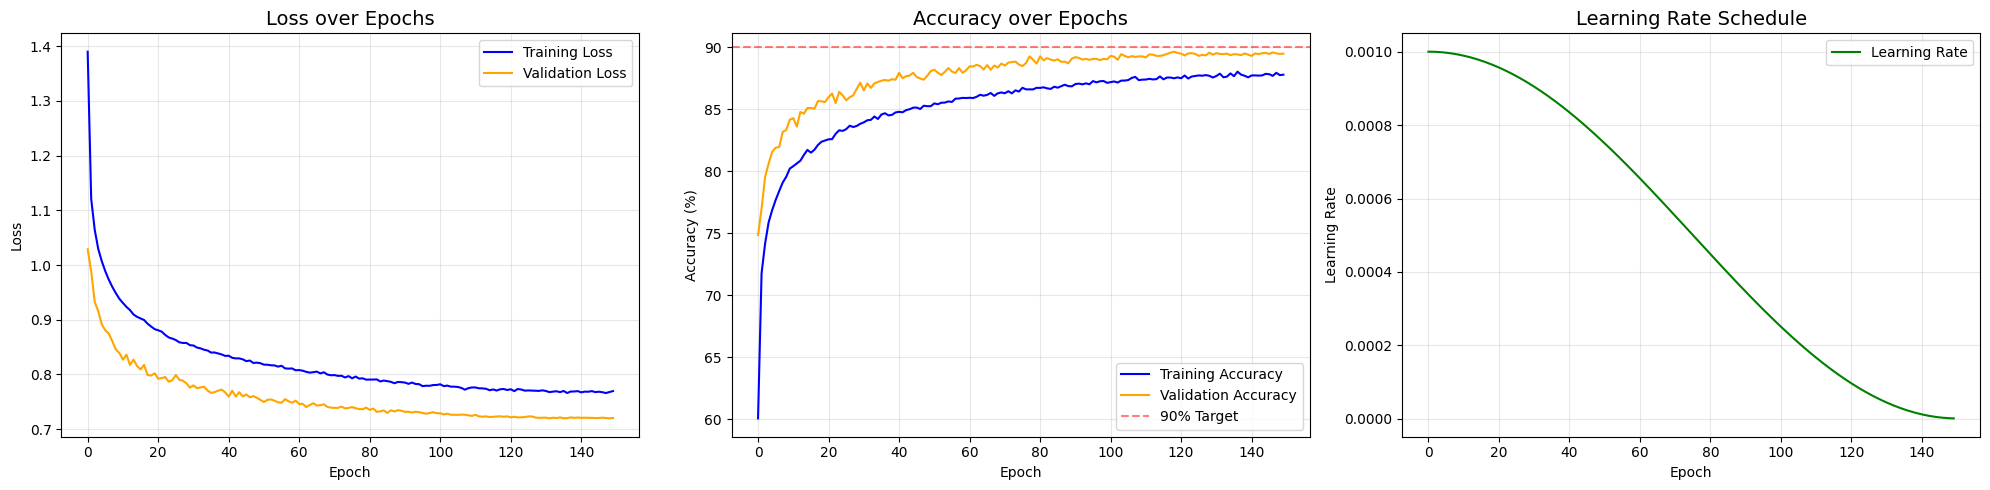

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Loss
axes[0].plot(loss_hist, label='Training Loss', color='blue')
axes[0].plot(loss_hist_val, label='Validation Loss', color='orange')
axes[0].set_title('Loss over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot([a*100 for a in acc_hist], label='Training Accuracy', color='blue')
axes[1].plot([a*100 for a in acc_hist_val], label='Validation Accuracy', color='orange')
axes[1].axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90% Target')
axes[1].set_title('Accuracy over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning Rate
axes[2].plot(lr_hist, label='Learning Rate', color='green')
axes[2].set_title('Learning Rate Schedule', fontsize=14)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##Save the trained model

In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), 'checkpoint.pth')
# # download checkpoint file
# files.download('checkpoint.pth')
# model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
# Select the best model based on validation accuracy
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc) + 1

print(f"Best validation accuracy: {best_acc*100:.2f}%")
print(f"Best epoch: {best_epoch}")

# Load the best model
with open(f"Models/MLP_model_{best_epoch}.pth", "rb") as f:
    model = pickle.load(f)

print("Best model loaded successfully!")

Best validation accuracy: 89.64%
Best epoch: 119
Best model loaded successfully!


#Compute Test Set Accuracy using the Trained Model

While it is important to achieve high training and validation accuracy, these metrics can sometimes be deceptive due to overfitting. On the other hand, the test accuracy provides a more reliable assessment of how well the model performs on new, unseen data, which is crucial for real-world applications.

Hence, it is essential to evaluate the performance of our best model by testing it on previously unseen data. This allows us to determine how effectively the model generalizes. Furthermore, **in the marking scheme of Assignment 1, emphasis is placed primarily on the test set accuracy of the model**, rather than the training or validation accuracy.



In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
total = 0

model.to(device)
model.eval()

with torch.no_grad():
    for batch, labels in test_loader:
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        test_loss += loss.item() * labels.size(0)

        pred_vec.extend(predicted.cpu().numpy())
        label_vec.extend(labels.cpu().numpy())

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

avg_test_loss = test_loss / total
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy on {len(test_set)} test images: {test_accuracy:.2f}%")

Test Loss: 0.7241
Test Accuracy on 5000 test images: 89.64%


# Display the Confusion Matrix

In [ ]:
# ---- Confusion Matrix ----
confusion_mat = confusion_matrix(label_vec, pred_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
display(confusion_df)

Confusion Matrix


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,413,1,2,9,2,2,61,0,3,1
Trouser,0,486,0,5,1,0,1,0,1,0
Pullover,7,0,414,7,44,0,34,0,0,0
Dress,8,4,2,480,14,0,8,0,4,0
Coat,0,0,38,11,407,0,30,0,0,0
Sandal,0,0,0,0,0,468,0,18,1,5
Shirt,57,1,31,15,39,0,359,0,4,0
Sneaker,0,0,0,0,0,2,0,482,0,9
Bag,3,0,1,2,1,0,1,4,487,0
Ankle boot,1,0,0,0,0,3,0,20,0,486


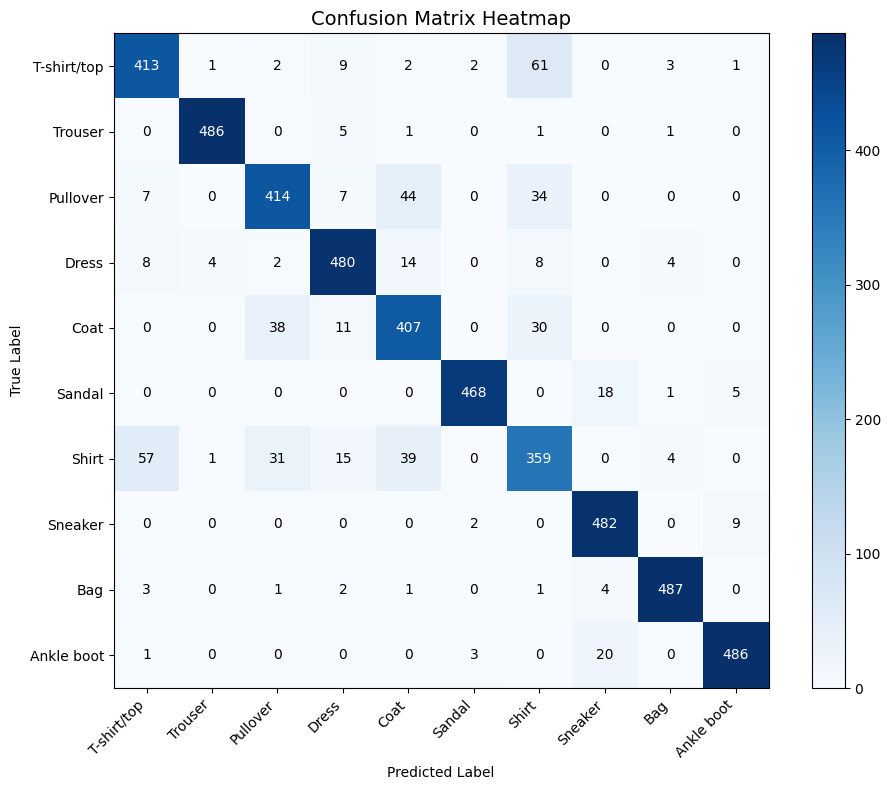

In [ ]:
# ---- Heatmap Visualization of Confusion Matrix ----
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap', fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion_mat[i, j]),
                 ha='center', va='center',
                 color='white' if confusion_mat[i, j] > confusion_mat.max()/2 else 'black')
plt.tight_layout()
plt.show()

# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [ ]:
# ---- Classification Report ----
report = pd.DataFrame.from_dict(
    classification_report(pred_vec, label_vec, output_dict=True)
).T
report['Label'] = [classes[int(x)] if x.isdigit() else " " for x in report.index]
report = report[['Label', 'f1-score', 'precision', 'recall', 'support']]
display(report)

,Label,f1-score,precision,recall,support
0,T-shirt/top,0.840285,0.836032,0.844581,489.0000
1,Trouser,0.985801,0.983806,0.987805,492.0000
2,Pullover,0.832998,0.818182,0.848361,488.0000
3,Dress,0.915157,0.923077,0.907372,529.0000
4,Coat,0.818913,0.837449,0.801181,508.0000
5,Sandal,0.967942,0.951220,0.985263,475.0000
6,Shirt,0.718000,0.709486,0.726721,494.0000
7,Sneaker,0.947886,0.977688,0.919847,524.0000
8,Bag,0.974975,0.975952,0.974000,500.0000
9,Ankle boot,0.961424,0.952941,0.970060,501.0000


In the context of classification, 'support' refers to the number of instances or samples in a dataset that belong to a specific class. It represents the frequency or count of occurrences of each class in the dataset.

Support values help assess the reliability and generalizability of classification models, as they indicate the amount of data available for each class and the potential challenges associated with imbalanced datasets.

# Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

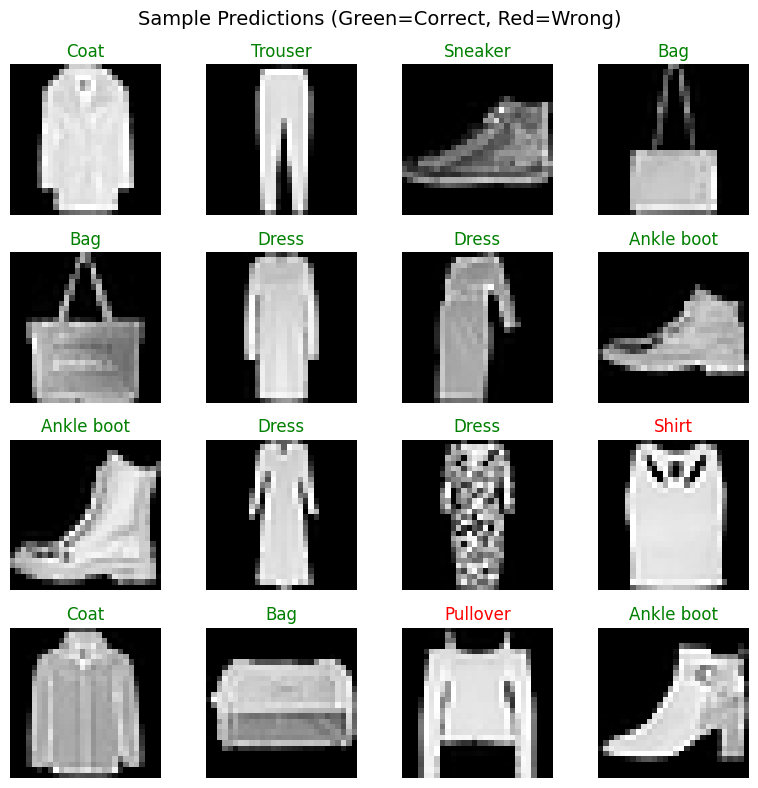

In [ ]:
# ---- Visualize Sample Test Results ----
images, labels = next(iter(test_loader))
model.cpu()
output = model(images)
_, preds = torch.max(output, 1)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for idx, ax in enumerate(axes.flat):
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.suptitle("Sample Predictions (Green=Correct, Red=Wrong)", fontsize=14)
plt.tight_layout()
plt.show()

#Display 50 Predicted Images in Reversed Grayscale
We iterate through 50 images and plot them with their corresponding label. We will color the label in blue if our model guessed correct and in red if it failed to predict that class.

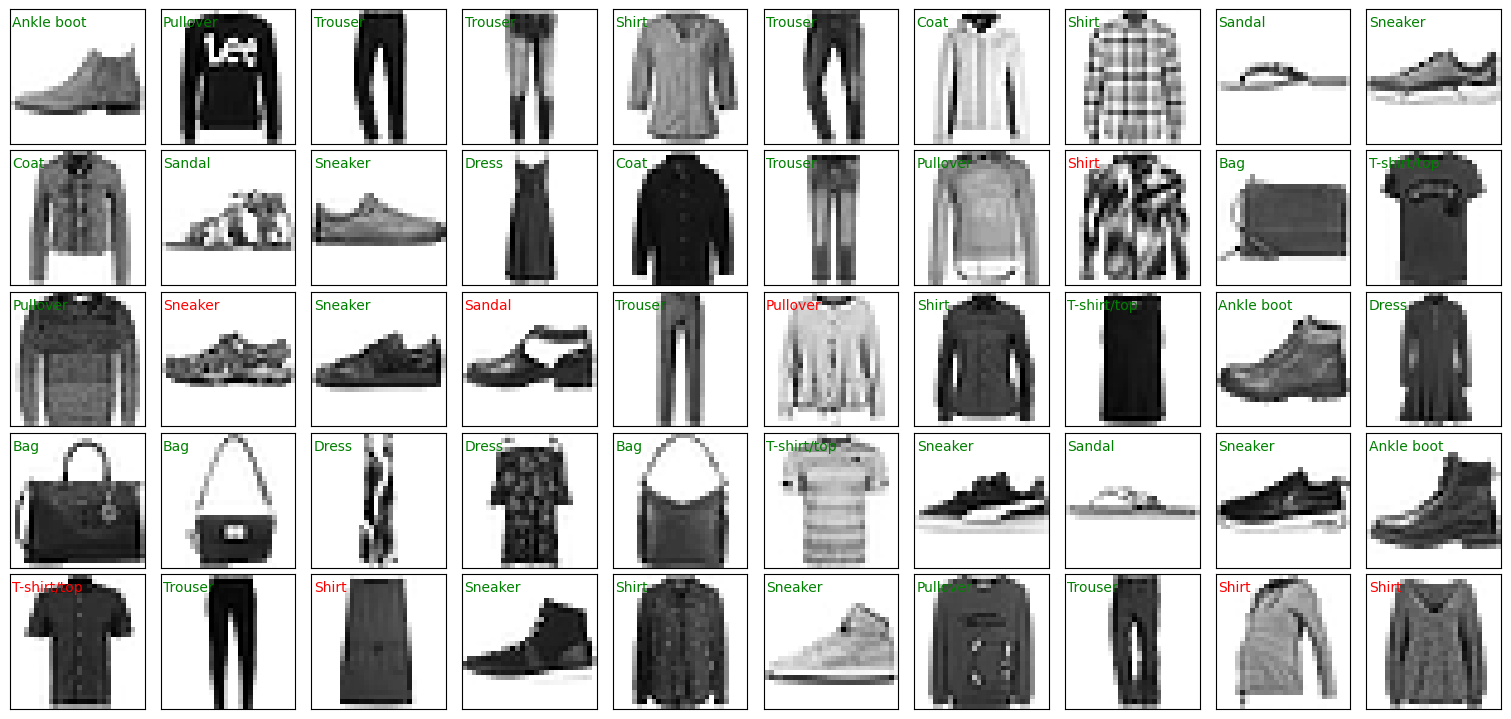

In [ ]:
# Define the loader for all test data
test_set_all = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=test_transform)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size=128, shuffle=False, num_workers=2)


# obtain one batch of test images
dataiter = iter(test_loader_all)
images, labels = next(iter(test_loader_all))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

    if preds[idx]==labels[idx]:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='green')
    else:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='red')

plt.show()


#Visualize wrongly classified image for each class

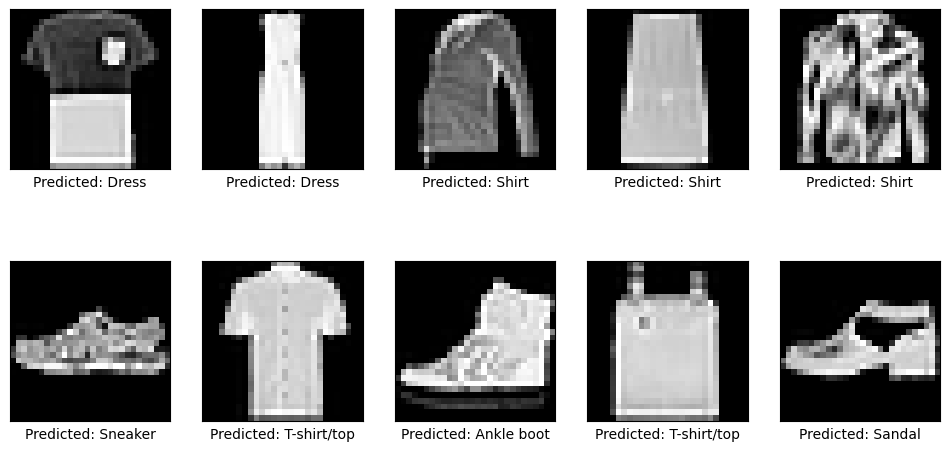

In [ ]:
# Visualize wrongly classified image for each class


pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1